In [18]:
import csv
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import statsmodels.api
import string

from collections import Counter 
from datetime import datetime
from IPython.display import display
from langdetect import detect, DetectorFactory
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from textblob import TextBlob

nltk.download("vader_lexicon")
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/merlekuehlenborg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/merlekuehlenborg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/merlekuehlenborg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/merlekuehlenborg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [19]:
#Loading the dataset
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)

df_trustpilot = pd.read_csv('data/data_trustpilot_first.csv', engine='python')

#Displaying basic information
print(df_trustpilot.columns)
print(df_trustpilot.info())
display(df_trustpilot.head())


Index(['username', 'number_reviews', 'location', 'rating', 'text',
       'date_posted', 'date_of_experience', 'verification', 'subject',
       'answer', 'company'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425109 entries, 0 to 425108
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   username            425075 non-null  object
 1   number_reviews      425109 non-null  int64 
 2   location            425109 non-null  object
 3   rating              425109 non-null  int64 
 4   text                425109 non-null  object
 5   date_posted         425109 non-null  object
 6   date_of_experience  425109 non-null  object
 7   verification        425109 non-null  object
 8   subject             425109 non-null  object
 9   answer              425109 non-null  object
 10  company             425109 non-null  object
dtypes: int64(2), object(9)
memory usage: 35.7+ MB
None


,username,number_reviews,location,rating,text,date_posted,date_of_experience,verification,subject,answer,company
0,Sstreetly,4,GB,1,Asda at fosse park leicester is old yes. Thoug...,2024-11-22 09:22:38,2024-11-20,Not Verified,Asda at fosse park leicester is old…,0,Asda
1,Ciaran,1,GB,1,Ordered flowers this morning and paid extra fo...,2024-11-22 12:21:22,2024-11-22,Not Verified,Ordered flowers this morning and paid…,0,Asda
2,Rosie Brocklehurst,63,GB,1,Why is Asda taking money for a grocery deliver...,2024-11-22 14:14:39,2024-11-22,Not Verified,Why is Asda taking money for a grocery…,0,Asda
3,Heidi Warfield,1,GB,1,I’m absolutely disgusted that a company like A...,2024-11-22 09:30:19,2024-11-19,Not Verified,I’m absolutely disgusted robbed by Asda that a...,0,Asda
4,Noetic Aphrodite,3,GB,1,"For those who haven't seen my previous review,...",2024-11-19 22:58:03,2024-11-19,Not Verified,For those who haven't seen my previous…,0,Asda


In [20]:
#Removes non-EN content
DetectorFactory.seed = 0

def is_english(text):
    try:
        if isinstance(text, str) and text.strip():
            return detect(text) == 'en'
        return False
    except:
        return False

def filter_english_content(df, batch_size=1000):
    text_results = []
    subject_results = []
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df.iloc[i:i + batch_size]
        text_results.extend([is_english(text) for text in batch['text']])
        subject_results.extend([is_english(text) for text in batch['subject']])
    
    mask = np.logical_and(text_results, subject_results)
    return df[mask].copy()

language_detection_stopwords = set(stopwords.words('english'))
company_words = {'Asda', 'SteelSeries', 'Quicken', 'LegalMatch', 'Solis', 'CheckURL', 'BeenVerified', 'FreedomPop',
'Rebtel', 'SmarterPhone', 'DSLExtreme', 'HubbleConnected', 'ConnectWise', 'HubSpot', 'SpyTecGPS',
'Pigeonly', 'Kandco', 'SCUFGaming', 'Inkfarm.com', 'StockX', 'CASETiFY', 'Toluna', 'PDFSimpli', 'SurveyJunkie'}
language_detection_stopwords.update(company_words)

df_trustpilot = filter_english_content(df_trustpilot)
print(f"Rows after filtering: {len(df_trustpilot)}")

100%|██████████| 426/426 [22:19<00:00,  3.15s/it]


Rows after filtering: 320087


STAGE 1 - CREATING NEW COLUMNS

In [21]:
#Convert date_posted and date_of_experience to datetime
df_trustpilot['date_posted'] = pd.to_datetime(df_trustpilot['date_posted'])
df_trustpilot['date_of_experience'] = pd.to_datetime(df_trustpilot['date_of_experience'])

#Create local_hour and local_date_posted
#Fixing the date_posted column
#The date_posted is from the CET timezone, however, there are countries in the list that are in a different timezone.
#That way, if someone posts at 9 pm in New York City, it appears as 3 am CET, potentially skewing the data.
#We need to fix this column so that date_posted represents the original date and time posted, from the view of the user writing the review.
#Maps the timezone difference from the view of the CET timezone

timezone_offsets = {
    'DE': 0, 'FR': 0, 'IT': 0, 'ES': 0, 'NL': 0, 'BE': 0, 'AT': 0, 'CH': 0, 'SE': 0,
    'DK': 0, 'NO': 0, 'PL': 0, 'CZ': 0, 'PT': 0, 'HU': 0, 'SK': 0, 'SI': 0, 'LU': 0,
    'MT': 0, 'HR': 0, 'BA': 0, 'AL': 0, 'ME': 0, 'RS': 0, 'MK': 0, 'AD': 0, 'LI': 0,
    'FI': 1, 'EE': 1, 'LV': 1, 'LT': 1, 'UA': 1, 'RO': 1, 'BG': 1, 'GR': 1, 'BY': 1,
    'MD': 1, 'TR': 1, 'CY': 1,
    'GB': -1, 'IE': -1, 'IM': -1, 'JE': -1, 'GG': -1, 'GI': -1,
    'RU': 3, 'KZ': 4, 'UZ': 5, 'KG': 5,
    'US': -7, 'CA': -7, 'MX': -7, 'PR': -6, 'VI': -6, 'GU': 10, 'GL': -3,
    'GT': -8, 'HN': -8, 'SV': -8, 'NI': -8, 'CR': -8, 'PA': -7,
    'BS': -7, 'CU': -7, 'JM': -7, 'DO': -6, 'BB': -6, 'TT': -6,
    'KN': -6, 'AG': -6, 'VC': -6, 'AI': -6, 'BM': -6, 'KY': -6,
    'TC': -6, 'AW': -6, 'CW': -6, 'BQ': -6, 'SX': -6, 'GP': -6,
    'BR': -5, 'AR': -5, 'CL': -6, 'CO': -7, 'VE': -6, 'PE': -7,
    'EC': -7, 'BO': -6, 'PY': -6, 'UY': -5,
    'CN': 7, 'JP': 8, 'KR': 8, 'TW': 7, 'MN': 7, 'HK': 7, 'MO': 7,
    'SG': 7, 'MY': 7, 'ID': 7, 'TH': 7, 'VN': 7, 'PH': 7,
    'MM': 6.5, 'KH': 7, 'BN': 7,
    'IN': 4.5, 'PK': 4, 'BD': 5, 'NP': 4.75, 'LK': 4.5, 'MV': 4,
    'AE': 3, 'SA': 2, 'IL': 2, 'IR': 2.5, 'IQ': 2, 'OM': 3,
    'KW': 2, 'QA': 2, 'BH': 2, 'JO': 2, 'LB': 2, 'AF': 3.5,
    'AM': 3, 'AZ': 3, 'GE': 3,
    'AU': 9, 'NZ': 11, 'FJ': 11, 'PF': 10, 'MP': 9,
    'ZA': 1, 'EG': 1, 'MA': 0, 'DZ': 0, 'TN': 0, 'LY': 1,
    'NG': 0, 'GH': 0, 'KE': 2, 'UG': 2, 'RW': 1, 'CD': 1,
    'GA': 0, 'CM': 0, 'ZW': 1, 'CI': 0, 'SS': 2,
    'RE': 3,
    'IS': -1, 'FO': -1, 'AX': 1,
    'XK': 0,
    'VG': -6, 'BZ': -7, 'SC': 3, 'BF': 0, 'MZ': 1, 'ET': 2,
    'SO': 2, 'SZ': 1, 'MC': 0, 'MU': 3, 'PS': 2, 'NC': 10,
    'MH': 11, 'BI': 1, 'PG': 9, 'ZM': 1, 'HT': -6, 'AO': 0,
    'TJ': 4, 'CG': 0, 'GY': -5, 'SN': 0,
    'GD': -6, 'GM': 0, 'SB': 10, 'SD': 1, 'MG': 2, 'SL': 0, 'DJ': 2, 'FK': -4,
    'FM': 10, 'SR': -4, 'MQ': -6, 'NR': 11, 'TD': 0, 'LR': 0, 'TG': 0, 'NE': 0,
    'MF': -6, 'ML': 0, 'CK': -11, 'LC': -6, 'BL': -6, 'TZ': 2, 'AS': -12, 'DM': -6,
    'WS': 12, 'GF': -4, 'MW': 1, 'PW': 8, 'SY': 1, 'LS': 1, 'VU': 10, 'LA': 6,
    'BW': 1, 'BJ': 0}

countries_in_df = df_trustpilot['location'].unique()
countries_in_mapping = set(timezone_offsets.keys())
missing_countries = set(countries_in_df) - countries_in_mapping
if len(missing_countries) > 0:
    print("Countries in dataset but not in timezone mapping:")
    print(missing_countries)
    print(f"Total missing countries: {len(missing_countries)}")
else:
    print("All countries in the dataset are covered in our timezone mapping!")

def adjust_to_local_time(df_trustpilot):
    df_trustpilot['local_hour'] = 0
    df_trustpilot['local_date_posted'] = None
    for country_code, offset in timezone_offsets.items():
        mask = df_trustpilot['location'] == country_code
        if offset != 0:  
            local_datetime = pd.to_datetime(df_trustpilot.loc[mask, 'date_posted']) + pd.Timedelta(hours=offset)
            df_trustpilot.loc[mask, 'local_date_posted'] = local_datetime.dt.date
            df_trustpilot.loc[mask, 'local_hour'] = local_datetime.dt.hour
    
    cet_mask = df_trustpilot['location'].isin([k for k, v in timezone_offsets.items() if v == 0])
    cet_datetime = pd.to_datetime(df_trustpilot.loc[cet_mask, 'date_posted'])
    df_trustpilot.loc[cet_mask, 'local_date_posted'] = cet_datetime.dt.date
    df_trustpilot.loc[cet_mask, 'local_hour'] = cet_datetime.dt.hour
    
    def evaluate_timezone_adjustment():
        null_local_hour = df_trustpilot['local_hour'].isnull().sum()
        null_local_date = df_trustpilot['local_date_posted'].isnull().sum()
        invalid_hours = df_trustpilot[~df_trustpilot['local_hour'].between(0, 23)].shape[0]
        date_changes = (df_trustpilot['local_date_posted'] != 
                       pd.to_datetime(df_trustpilot['date_posted']).dt.date).sum()
        print("Evaluation Results:")
        print(f"Missing local hours: {null_local_hour}")
        print(f"Missing local dates: {null_local_date}")
        print(f"Invalid hours (not 0-23): {invalid_hours}")
        print(f"Number of date changes due to timezone adjustment: {date_changes}")
        if date_changes > 0:
            print("Sample of records where date changed:")
            date_change_mask = (df_trustpilot['local_date_posted'] != 
                              pd.to_datetime(df_trustpilot['date_posted']).dt.date)
            sample_changes = df_trustpilot[date_change_mask].sample(min(5, date_changes))
            print(sample_changes[['location', 'date_posted', 'local_date_posted', 'local_hour']].to_string())
    evaluate_timezone_adjustment()

    return df_trustpilot

df_trustpilot = adjust_to_local_time(df_trustpilot)
df_trustpilot['local_hour'] = df_trustpilot['local_hour'].astype('int')
df_trustpilot['local_date_posted'] = pd.to_datetime(df_trustpilot['local_date_posted'])

All countries in the dataset are covered in our timezone mapping!
Evaluation Results:
Missing local hours: 0
Missing local dates: 0
Invalid hours (not 0-23): 0
Number of date changes due to timezone adjustment: 72572
Sample of records where date changed:
       location         date_posted local_date_posted  local_hour
312588       PH 2024-08-27 19:32:01        2024-08-28           2
309209       PH 2024-09-19 22:18:07        2024-09-20           5
398761       US 2022-03-06 03:41:09        2022-03-05          20
89725        CA 2023-08-11 02:51:47        2023-08-10          19
191570       US 2023-04-29 03:23:01        2023-04-28          20


In [22]:
#Creating days_between_experience_and_post
df_trustpilot['days_between_experience_and_post'] = (df_trustpilot['local_date_posted'] - df_trustpilot['date_of_experience']).dt.days

# Creating day_of_week_posted by extracting day of week (Monday=0, Sunday=6)
df_trustpilot['day_of_week_posted'] = df_trustpilot['local_date_posted'].dt.dayofweek

In [23]:
#Creating columns time_of_day, day_type and month_name
def create_time_features(df):
    def categorize_hour(hour):
        if 5 < hour <= 8:
            return 'Morning'
        elif 9 <= hour <= 17:
            return 'Business Hours'
        elif 18 <= hour <= 22:
            return 'Evening'
        else:
            return 'Night'
    def categorize_day(day):
        if day in [0, 1, 2, 3, 4]:  
            return 'Business Day'
        else:
            return 'Weekend'
    df['time_of_day'] = df['local_hour'].apply(categorize_hour)
    df['day_type'] = df['day_of_week_posted'].apply(categorize_day)
    df['month_name'] = df['local_date_posted'].dt.strftime('%B')
    return df

df_trustpilot = create_time_features(df_trustpilot)

print("Text columns distributions:")
text_columns = ['time_of_day', 'day_type', 'month_name']
for col in text_columns:
    print(f"{col} value counts:")
    print(df_trustpilot[col].value_counts())
print("Numeric columns statistics:")
print("Checking for null values in new columns:")
all_new_columns = text_columns 
print(df_trustpilot[all_new_columns].isnull().sum())

Text columns distributions:
time_of_day value counts:
time_of_day
Business Hours    180595
Evening            70877
Morning            37201
Night              31414
Name: count, dtype: int64
day_type value counts:
day_type
Business Day    243598
Weekend          76489
Name: count, dtype: int64
month_name value counts:
month_name
March        30824
April        30395
December     29962
May          29229
November     26599
October      26123
August       25351
September    25101
June         24899
January      24835
July         24638
February     22131
Name: count, dtype: int64
Numeric columns statistics:
Checking for null values in new columns:
time_of_day    0
day_type       0
month_name     0
dtype: int64


In [24]:
# Binary encoding for answer presence
# 0 = no answer provided
# 1 = answer provided 
df_trustpilot['answered_encoded'] = np.where(df_trustpilot['answer'] == '0', 0, 1).astype('int')

In [25]:
# Calculate and display distribution statistics
total_users = len(df_trustpilot)
repeat = (df_trustpilot['number_reviews'] >= 2).sum()
pct_repeat = (repeat / total_users) * 100
onetime = (df_trustpilot['number_reviews'] < 2).sum()
pct_onetime = (onetime / total_users) * 100
print("Percentage of users with >= 2 reviews: ", pct_repeat)
print("Percentage of users with < 2 reviews: ", pct_onetime)

# Create categorical column for visualization/EDA
df_trustpilot['repeat_reviewer'] = np.where(df_trustpilot['number_reviews'] >= 2, 'repeat', 'one-time')

# Binary encode for modeling (0 = one-time, 1 = repeat)
df_trustpilot['repeat_reviewer_encoded'] = (df_trustpilot['number_reviews'] >= 2).astype('int')

Percentage of users with >= 2 reviews:  36.6869007488589
Percentage of users with < 2 reviews:  63.31309925114109


In [26]:
#Creating a column called review_time from days_between_experience_and_post indicating whether the user did an immediate review (<1) or a late review (>=1)
total_reviews = len(df_trustpilot)
quick = (df_trustpilot['days_between_experience_and_post'] < 1).sum()
pct_quick = (quick / total_reviews) * 100
late = (df_trustpilot['days_between_experience_and_post'] >= 1).sum()
pct_late = (late / total_reviews) * 100
print("Percentage of reviews with < 1 days of experience: ", pct_quick)
print("Percentage of reviews with >= 1 days of experience: ", pct_late)

#Creating the column
df_trustpilot['review_time'] = np.where(df_trustpilot['days_between_experience_and_post'] <1, 'quick_review', 'late_review')

#Encoding review_time
#0 = late_review
#1 = quick_review

df_trustpilot['review_time_encoded'] = (df_trustpilot['days_between_experience_and_post'] < 1).astype('int')

Percentage of reviews with < 1 days of experience:  61.91660392330836
Percentage of reviews with >= 1 days of experience:  38.08339607669165


In [27]:
#Converting month_name

print(df_trustpilot['month_name'].unique())
month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12}
df_trustpilot['month_local'] = df_trustpilot['month_name'].map(month_map)
df_trustpilot = df_trustpilot.drop('month_name', axis=1)

#Result: Column 'month_local' now displays the numeric values of the month (e.g. 3 for March)
#Deletes the column month_name as it contains the exact same information as month_local

['November' 'October' 'September' 'August' 'July' 'June' 'May' 'April'
 'March' 'February' 'January' 'December']


STAGE 2 - BASIC TEXT PREPROCESSING

Number of reviews containing emails: [nan 'export@munnadyechemindustries.com' 'langfordjw@sbcglobal.net'
 'ptheib@gmail.com' 'HankR60@basicisp.net' 'URBAN.RT@GMAIL.COM'
 'kjbus101@cox.net' 'ltbl@juno.com.' 'mygigi89@aol.com'
 'jdemerchant@bell.net']
Number of reviews containing URLs: [nan]


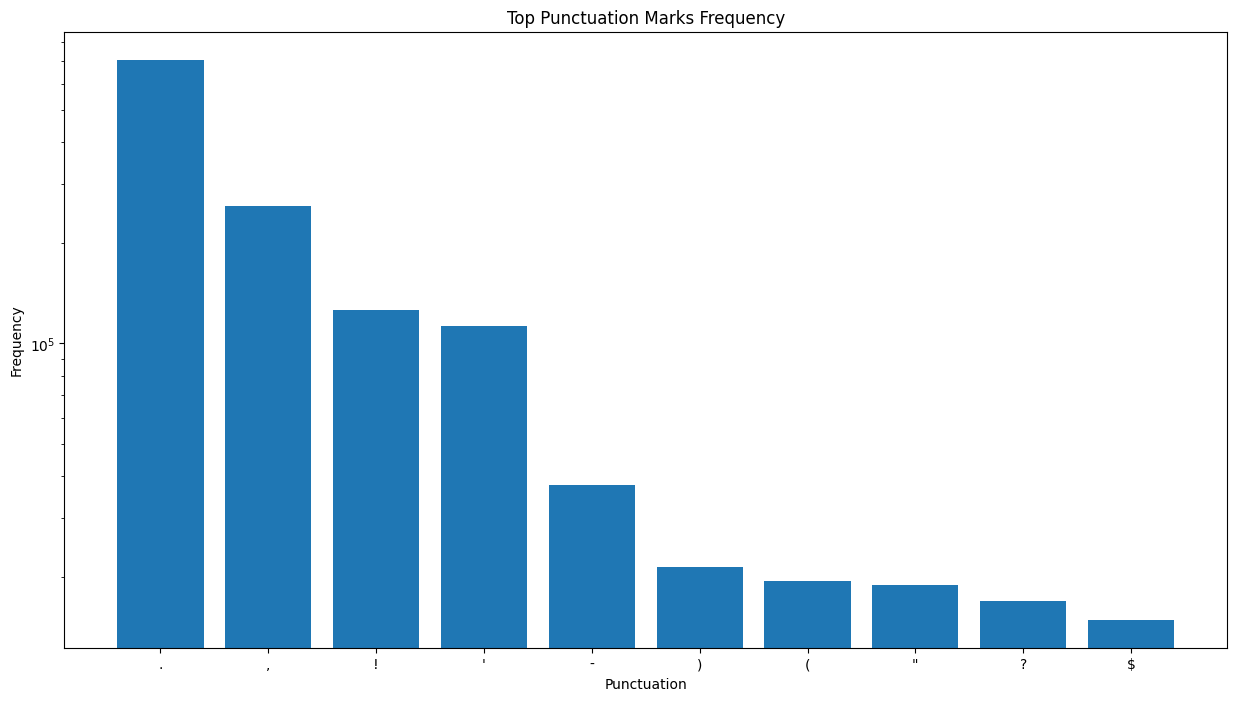

Average character length of text: 142.32 characters
Average character length of subject: 23.45 characters
Average word length of text: 23.33 words
Average word length of subject: 3.91 words
Most common words:
not: 109583
you: 100464
they: 93451
great: 88999
but: 87658
survey: 79234
time: 76699
very: 73928
service: 72968
case: 68880
so: 63193
good: 62769
from: 59256
easy: 57190
order: 54733
product: 49789
customer: 48627
shoe: 46920
no: 46655
all: 42336


In [29]:
#Removing the stop words
sentiment_stop_words = {'a', 'an', 'the', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'wa', 'i', 
                        'and', 'it', 'my', 'is', 'have', 'get', 'that', 'this', 'me', 'are', 'a', 'be', 'had', 
                        'when', 'them', 'will', 'or', 'ha', 'about', 'im'}
stop_words_for_processing = sentiment_stop_words.union(company_words)

def remove_stopwords(text):
    if isinstance(text, str):
        lemmatizer = WordNetLemmatizer()
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        words = word_tokenize(text)
        filtered_words = [lemmatizer.lemmatize(word) for word in words 
                        if word.lower() not in stop_words_for_processing]
        return ' '.join(filtered_words)
    return text

df_trustpilot['text_processed'] = df_trustpilot['text'].apply(remove_stopwords)
df_trustpilot['subject_processed'] = df_trustpilot['subject'].apply(remove_stopwords)
df_trustpilot['answer_processed'] = df_trustpilot['answer'].apply(remove_stopwords)

# Email extraction
pat_mail = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
df_trustpilot['email'] = df_trustpilot['text'].str.extract(pat_mail, expand=False)

# Check unique emails found
print("Number of reviews containing emails:", df_trustpilot['email'].unique())

# URL extraction
pat_link = r'(https?://(?:www\.)?\w+\.\w{2,}(?:/\S*)?)'
df_trustpilot['link'] = df_trustpilot['text'].str.extract(pat_link, expand=False)

# Check unique links found
print("Number of reviews containing URLs:", df_trustpilot['link'].unique())

# List of punctuation marks to count
punctuation_marks = list(string.punctuation)

# Store punctuation counts in a single column as dictionaries
df_trustpilot['punctuation_counts'] = df_trustpilot['text'].apply(
    lambda x: dict(Counter(c for c in x if c in punctuation_marks)))

# Aggregate all punctuation counts
all_punctuation_counts = Counter()
df_trustpilot['punctuation_counts'].apply(lambda x: all_punctuation_counts.update(x))

# Visualize the most frequent punctuation marks
top_punctuation = dict(all_punctuation_counts.most_common(10))  
plt.figure(figsize=(15, 8))
plt.bar(top_punctuation.keys(), top_punctuation.values())
plt.yscale('log')
plt.title("Top Punctuation Marks Frequency")
plt.xlabel("Punctuation")
plt.ylabel("Frequency")
plt.show()

# Calculate character length for both text and subject columns
df_trustpilot['text_length'] = df_trustpilot['text_processed'].apply(len)
df_trustpilot['subject_length'] = df_trustpilot['subject_processed'].apply(len)
average_length = df_trustpilot['text_length'].mean()
average_subject_length = df_trustpilot['subject_length'].mean()
print(f"Average character length of text: {average_length:.2f} characters")
print(f"Average character length of subject: {average_subject_length:.2f} characters")

# Calculate average word length
df_trustpilot['text_word_length'] = df_trustpilot['text_processed'].apply(lambda x: len(x.split()))
df_trustpilot['subject_word_length'] = df_trustpilot['subject_processed'].apply(lambda x: len(x.split()))
avg_text_words = df_trustpilot['text_word_length'].mean()
avg_subject_words = df_trustpilot['subject_word_length'].mean()
print(f"Average word length of text: {avg_text_words:.2f} words")
print(f"Average word length of subject: {avg_subject_words:.2f} words")

# Common words analysis
all_text = ' '.join(df_trustpilot['text_processed']) + ' ' + ' '.join(df_trustpilot['subject_processed'])
words = word_tokenize(all_text.lower())
word_counts = Counter(words)
common_words = [(word, count) for word, count in word_counts.most_common(500)
                if word not in stop_words_for_processing]

print("Most common words:")
for word, count in common_words[:20]:  
    print(f"{word}: {count}")


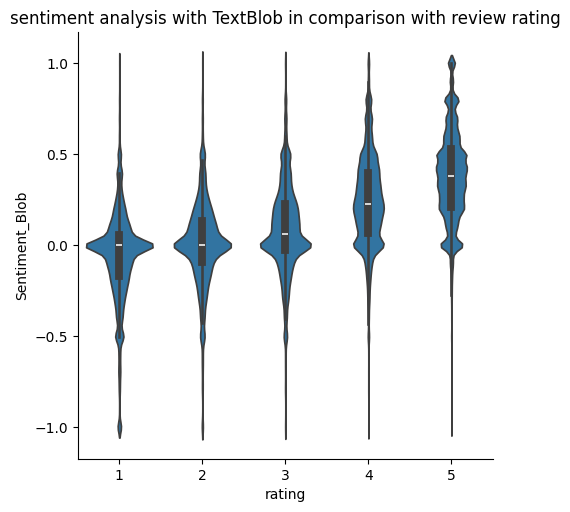

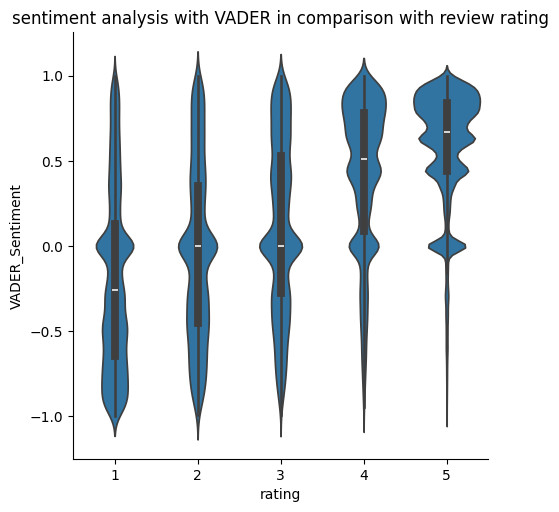

0.20662194965743688
0.189648439330557


In [30]:
#Basic sentiment scores

#Function returning the sentiment calculated by TextBlob
def sentiment_analysis(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity
df_trustpilot['Sentiment_Blob'] = df_trustpilot['text_processed'].apply(lambda text: sentiment_analysis(str(text)))

sns.catplot(x="rating",y="Sentiment_Blob", kind="violin", data=df_trustpilot)
plt.title("sentiment analysis with TextBlob in comparison with review rating")
plt.show();
sia = SentimentIntensityAnalyzer()

# Function giving the VADER sentiment back
def vader_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores['compound']

df_trustpilot['VADER_Sentiment'] = df_trustpilot['text_processed'].apply(lambda text: vader_sentiment(str(text)))
df_trustpilot.head()

sns.catplot(x="rating",y="VADER_Sentiment", kind="violin", data=df_trustpilot)
plt.title("sentiment analysis with VADER in comparison with review rating")
plt.show();

def create_rating_based_sentiment_bins(df, sentiment_column):
    sentiment_ranges = {}
    for rating in df['rating'].unique():
        mask = df['rating'] == rating
        sentiment_ranges[rating] = df.loc[mask, sentiment_column].quantile([0.2, 0.4, 0.6, 0.8]).values
    def categorize_sentiment(row):
        ranges = sentiment_ranges[row['rating']]
        sentiment = row[sentiment_column]
        if sentiment <= ranges[0]: return 1
        elif sentiment <= ranges[1]: return 2
        elif sentiment <= ranges[2]: return 3
        elif sentiment <= ranges[3]: return 4
        else: return 5
    return df.apply(categorize_sentiment, axis=1)

df_trustpilot["Sentiment_Blob_cat"] = create_rating_based_sentiment_bins(df_trustpilot, 'Sentiment_Blob')
df_trustpilot["Sentiment_VADER_cat"] = create_rating_based_sentiment_bins(df_trustpilot, 'VADER_Sentiment')

cm = pd.crosstab(df_trustpilot.rating, df_trustpilot.Sentiment_Blob_cat, rownames = ["Rating"], colnames = ["Sentiment category from TextBlob"])
cm

#Calculating true positives for TextBlob
TP_TextBlob = cm.loc[1,1]+cm.loc[2,2]+cm.loc[3,3]+cm.loc[4,4]+cm.loc[5,5]
total_num = df_trustpilot.shape[0]
TP_rate = TP_TextBlob/total_num
print(TP_rate)

cm = pd.crosstab(df_trustpilot.rating, df_trustpilot.Sentiment_VADER_cat, rownames = ["Rating"], colnames = ["Sentiment category from VADER"])
cm

#Calculating true positives for VADER
TP_VADER = cm.loc[1,1]+cm.loc[2,2]+cm.loc[3,3]+cm.loc[4,4]+cm.loc[5,5]
total_num = df_trustpilot.shape[0]
TP_rate = TP_VADER/total_num
print(TP_rate)

Word frequencies:
unhelpful             415
poor quality          422
bad experience        674
never again           694
not working           776
awful                1222
avoid                1315
still waiting        1320
delayed              1379
disappointing        1473
annoying             1539
wonderful            1545
fantastic            1547
usually              1858
horrible             1941
highly recommend     2214
great product        2407
worst                2550
reliable             2573
great experience     2774
frustrating          2789
terrible             2952
immediately          2989
pleased              3003
poor                 3086
waste                3379
great service        3581
sometimes            3814
satisfied            4023
first time           5427
amazing              5619
excellent            6715
perfect              6903
helpful              7054
best                 9529
recommend            9704
always              12230
never               

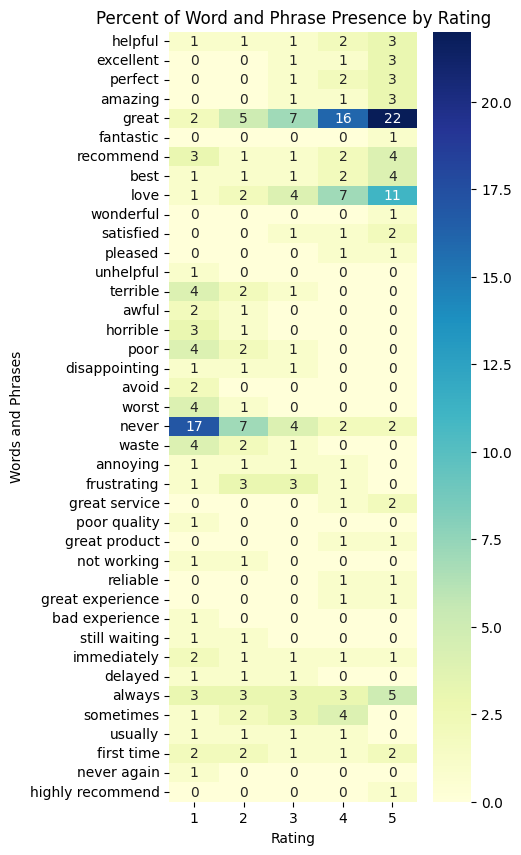

In [32]:
#Analysis of word frequencies
def analyze_word_frequencies(df_trustpilot, word_list):
    word_frequencies = pd.DataFrame(index=df_trustpilot.index)
    for word in word_list:
        word_frequencies[word] = df_trustpilot['text_processed'].str.contains(
            fr'\b{word}\b', case=False, na=False).astype(int)
    
    column_totals = word_frequencies.sum().sort_values(ascending=True)
    print("Word frequencies:")
    print(column_totals)
    
    result_df = pd.DataFrame()
    for word in word_list:
        grouped = pd.DataFrame({'text': df_trustpilot['text_processed'], 'rating': df_trustpilot['rating'],
            'word_present': word_frequencies[word]}).groupby('rating')['word_present']
        result_df[word] = (grouped.mean() * 100).round(0)
    
    plt.figure(figsize=(4, 10))
    sns.heatmap(result_df.T, annot=True, cmap="YlGnBu", fmt='g')
    plt.xlabel("Rating")
    plt.ylabel("Words and Phrases")
    plt.title("Percent of Word and Phrase Presence by Rating")
    plt.show()

    return result_df

word_list = [
    'helpful', 'excellent', 'perfect', 'amazing', 'great', 'fantastic', 
    'recommend', 'best', 'love', 'wonderful', 'satisfied', 'pleased',
    'unhelpful', 'terrible', 'awful', 'horrible', 'poor', 'disappointing',
    'avoid', 'worst', 'never', 'waste', 'annoying', 'frustrating',
    'great service', 'poor quality','great product', 'not working', 'reliable', 
    'great experience', 'bad experience', 'still waiting', 
    'immediately', 'delayed', 'always', 'never', 'sometimes', 'usually',
    'first time',  'never again','highly recommend']

result_df = analyze_word_frequencies(df_trustpilot, word_list)


1-star reviews most common words:
  not: 44831
  they: 42632
  you: 30938
  no: 22527
  but: 21906
  order: 20796
  from: 19875
  service: 19084
  customer: 18712
  time: 18637

2-star reviews most common words:
  not: 11405
  but: 7376
  you: 6883
  they: 6048
  time: 5702
  case: 4945
  so: 4398
  survey: 4206
  from: 3896
  no: 3760

3-star reviews most common words:
  not: 13829
  but: 12265
  you: 9211
  survey: 8977
  time: 7781
  case: 6790
  they: 5950
  so: 5674
  like: 5150
  from: 4473

4-star reviews most common words:
  but: 15622
  survey: 13093
  you: 11236
  not: 10300
  time: 8634
  good: 8555
  great: 7374
  case: 7271
  so: 6984
  they: 6889

5-star reviews most common words:
  great: 41418
  very: 34632
  you: 31814
  easy: 30034
  survey: 26971
  they: 25536
  good: 24158
  case: 23723
  time: 23564
  service: 23304


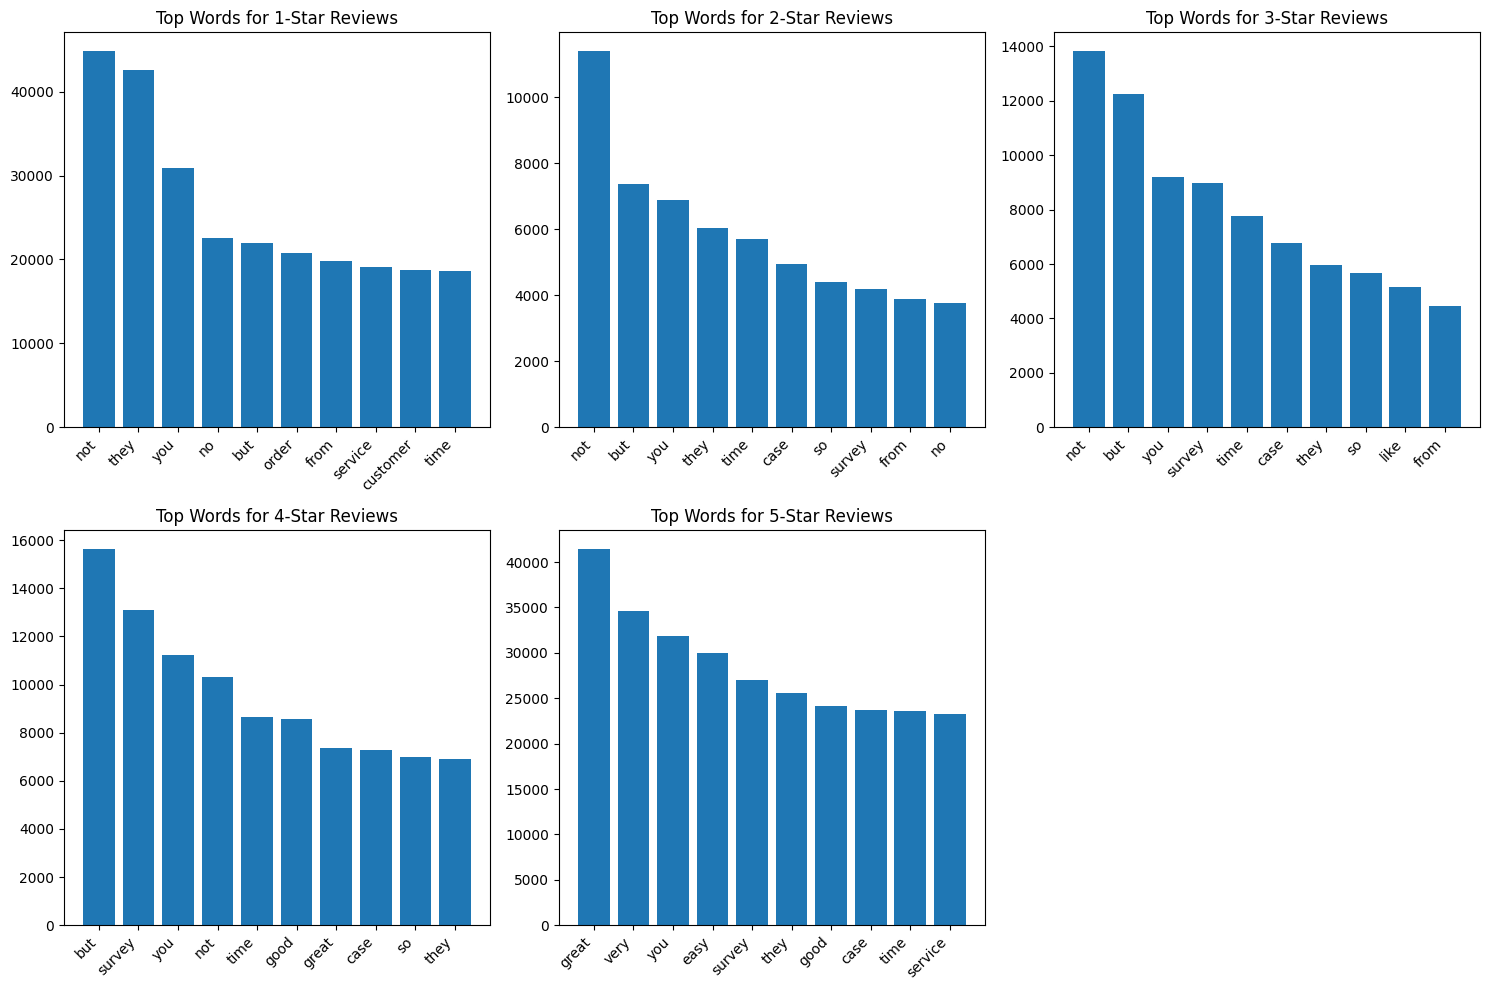

In [33]:
#Analyzing common words by rating
rating_words = {}
for rating in sorted(df_trustpilot['rating'].unique()):
    texts = df_trustpilot[df_trustpilot['rating'] == rating]['text_processed']
    all_words = ' '.join(texts).split()
    word_freq = Counter(w for w in all_words 
                       if w not in stop_words_for_processing).most_common(10)
    rating_words[rating] = word_freq
    print(f"\n{rating}-star reviews most common words:")
    for word, count in word_freq:
        print(f"  {word}: {count}")

plt.figure(figsize=(15, 10))
for i, rating in enumerate(sorted(rating_words.keys()), 1):
    plt.subplot(2, 3, i)
    words, counts = zip(*rating_words[rating])
    plt.bar(words, counts)
    plt.title(f'Top Words for {rating}-Star Reviews')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
plt.show()

In [34]:
#Rearranging the order of the columns
print("Current column order:", df_trustpilot.columns.tolist())

df_trustpilot.rename(columns={'VADER_Sentiment': 'Sentiment_VADER'}, inplace=True)

display(df_trustpilot.head())

df_trustpilot = df_trustpilot[['rating', 'location', 'username', 'number_reviews', 'verification','repeat_reviewer', 'repeat_reviewer_encoded', 'company', 
                               'text', 'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob', 'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat', 
                               'subject', 'subject_processed', 'subject_length', 'subject_word_length', 'answer', 'answer_processed', 'answered_encoded', 
                               'date_of_experience', 'date_posted', 'local_date_posted', 'month_local', 'local_hour', 'time_of_day', 
                               'day_of_week_posted', 'day_type', 'days_between_experience_and_post', 'review_time', 'review_time_encoded', 'punctuation_counts']]

Current column order: ['username', 'number_reviews', 'location', 'rating', 'text', 'date_posted', 'date_of_experience', 'verification', 'subject', 'answer', 'company', 'local_hour', 'local_date_posted', 'days_between_experience_and_post', 'day_of_week_posted', 'time_of_day', 'day_type', 'answered_encoded', 'repeat_reviewer', 'repeat_reviewer_encoded', 'review_time', 'review_time_encoded', 'month_local', 'text_processed', 'subject_processed', 'answer_processed', 'email', 'link', 'punctuation_counts', 'text_length', 'subject_length', 'text_word_length', 'subject_word_length', 'Sentiment_Blob', 'VADER_Sentiment', 'Sentiment_Blob_cat', 'Sentiment_VADER_cat']


,username,number_reviews,location,rating,text,date_posted,date_of_experience,verification,subject,answer,company,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted,time_of_day,day_type,answered_encoded,repeat_reviewer,repeat_reviewer_encoded,review_time,review_time_encoded,month_local,text_processed,subject_processed,answer_processed,email,link,punctuation_counts,text_length,subject_length,text_word_length,subject_word_length,Sentiment_Blob,Sentiment_VADER,Sentiment_Blob_cat,Sentiment_VADER_cat
0,Sstreetly,4,GB,1,Asda at fosse park leicester is old yes. Thoug...,2024-11-22 09:22:38,2024-11-20,Not Verified,Asda at fosse park leicester is old…,0,Asda,8,2024-11-22,2,4,Morning,Business Day,0,repeat,1,late_review,0,11,asda fosse park leicester old yes though reall...,asda fosse park leicester old,0,NaN,NaN,"{'.': 2, ''': 2, '?': 1}",330,29,54,5,0.111099,0.8685,5,5
1,Ciaran,1,GB,1,Ordered flowers this morning and paid extra fo...,2024-11-22 12:21:22,2024-11-22,Not Verified,Ordered flowers this morning and paid…,0,Asda,11,2024-11-22,0,4,Business Hours,Business Day,0,one-time,0,quick_review,1,11,ordered flower morning paid extra express deli...,ordered flower morning paid,0,NaN,NaN,"{'-': 2, '.': 4, ''': 1, '!': 1}",301,27,47,4,0.100000,0.3612,5,5
2,Rosie Brocklehurst,63,GB,1,Why is Asda taking money for a grocery deliver...,2024-11-22 14:14:39,2024-11-22,Not Verified,Why is Asda taking money for a grocery…,0,Asda,13,2024-11-22,0,4,Business Hours,Business Day,0,repeat,1,quick_review,1,11,why asda taking money grocery delivery day bef...,why asda taking money grocery,0,NaN,NaN,"{'.': 5, ''': 1}",375,29,62,5,0.043333,-0.2263,4,3
3,Heidi Warfield,1,GB,1,I’m absolutely disgusted that a company like A...,2024-11-22 09:30:19,2024-11-19,Not Verified,I’m absolutely disgusted robbed by Asda that a...,0,Asda,8,2024-11-22,3,4,Morning,Business Day,0,one-time,0,late_review,0,11,absolutely disgusted company like asda ha robb...,absolutely disgusted robbed asda company,0,NaN,NaN,"{'.': 3, ',': 1}",304,40,54,5,-0.288889,-0.6531,1,2
4,Noetic Aphrodite,3,GB,1,"For those who haven't seen my previous review,...",2024-11-19 22:58:03,2024-11-19,Not Verified,For those who haven't seen my previous…,0,Asda,21,2024-11-19,0,1,Evening,Business Day,0,repeat,1,quick_review,1,11,those who havent seen previous review if asda ...,those who havent seen previous,0,NaN,NaN,"{''': 1, ',': 3, '/': 2, '.': 3, ':': 1, '-': ...",354,30,56,5,0.217424,0.6369,5,5


In [35]:
#Last check
print(df_trustpilot.columns)
print(df_trustpilot.info())
display(df_trustpilot.head())

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded', 'punctuation_counts'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 320087 entries, 0 to 425107
Data columns (total 35 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   rating                         

,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,text_length,text_word_length,Sentiment_Blob,Sentiment_Blob_cat,Sentiment_VADER,Sentiment_VADER_cat,subject,subject_processed,subject_length,subject_word_length,answer,answer_processed,answered_encoded,date_of_experience,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded,punctuation_counts
0,1,GB,Sstreetly,4,Not Verified,repeat,1,Asda,Asda at fosse park leicester is old yes. Thoug...,asda fosse park leicester old yes though reall...,330,54,0.111099,5,0.8685,5,Asda at fosse park leicester is old…,asda fosse park leicester old,29,5,0,0,0,2024-11-20,2024-11-22 09:22:38,2024-11-22,11,8,Morning,4,Business Day,2,late_review,0,"{'.': 2, ''': 2, '?': 1}"
1,1,GB,Ciaran,1,Not Verified,one-time,0,Asda,Ordered flowers this morning and paid extra fo...,ordered flower morning paid extra express deli...,301,47,0.100000,5,0.3612,5,Ordered flowers this morning and paid…,ordered flower morning paid,27,4,0,0,0,2024-11-22,2024-11-22 12:21:22,2024-11-22,11,11,Business Hours,4,Business Day,0,quick_review,1,"{'-': 2, '.': 4, ''': 1, '!': 1}"
2,1,GB,Rosie Brocklehurst,63,Not Verified,repeat,1,Asda,Why is Asda taking money for a grocery deliver...,why asda taking money grocery delivery day bef...,375,62,0.043333,4,-0.2263,3,Why is Asda taking money for a grocery…,why asda taking money grocery,29,5,0,0,0,2024-11-22,2024-11-22 14:14:39,2024-11-22,11,13,Business Hours,4,Business Day,0,quick_review,1,"{'.': 5, ''': 1}"
3,1,GB,Heidi Warfield,1,Not Verified,one-time,0,Asda,I’m absolutely disgusted that a company like A...,absolutely disgusted company like asda ha robb...,304,54,-0.288889,1,-0.6531,2,I’m absolutely disgusted robbed by Asda that a...,absolutely disgusted robbed asda company,40,5,0,0,0,2024-11-19,2024-11-22 09:30:19,2024-11-22,11,8,Morning,4,Business Day,3,late_review,0,"{'.': 3, ',': 1}"
4,1,GB,Noetic Aphrodite,3,Not Verified,repeat,1,Asda,"For those who haven't seen my previous review,...",those who havent seen previous review if asda ...,354,56,0.217424,5,0.6369,5,For those who haven't seen my previous…,those who havent seen previous,30,5,0,0,0,2024-11-19,2024-11-19 22:58:03,2024-11-19,11,21,Evening,1,Business Day,0,quick_review,1,"{''': 1, ',': 3, '/': 2, '.': 3, ':': 1, '-': ..."


In [36]:
import os

os.makedirs('data', exist_ok=True)

csv_path = 'data/data_trustpilot.csv.gz'  
df_trustpilot.to_csv(csv_path, index=False, compression='gzip', encoding='utf-8') 
print(f"DataFrame exported to {csv_path}")

DataFrame exported to data/data_trustpilot.csv.gz
